In [1]:
import pyvisa
import numpy as np
import time
import pandas as pd
import os
import math
import CVCommands
from pyvisa import ResourceManager, constants
from scipy.optimize import curve_fit, minimize, leastsq
from datetime import datetime
from simple_pid import PID
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from usb.core import find as finddev

In [8]:
sampName = 'CS623C_002_air'

Vbias = 0.968

freq_i = 1 #Initial freq order of magnitude (Hz)
freq_f = 6 #Final freq order of magnitude (Hz)
freq_step = 100 #Number of steps


num_avg = 5 #Number of measurements to average

delay = .1 #Delay between changing to new value

amp = 0.05
holdbias = True #Toggle to hold device at bias before measurement
hold_val = Vbias #Voltage to hold at in V
hold_time = 2*60 #Time to hold voltage in s

ϵ = 25 #relative permitivity
ϵo = 8.85e-12 #permitivity of free space (m-3 kg-1 s4 A2)
q = 1.602e-19 #elementary charge (A.s)
A = 0.17*1e-4 #cell area (m)

####################################################

#PID tuning parameters for V setpoint
Ku = 1.3
Tu = 1
CVCommands.P = 0.45*Ku    #3.06
CVCommands.I = 0.54*Ku/Tu    #2.8
CVCommands.D = 0.0

CVCommands.offset = 0.005 #Acceptable tolerance for voltage setpoint in V

CVCommands.reset_i = 0 #Subtract this value from voltage setpoint to improve PID speed
CVCommands.reset = 5 #Subtract value from setpoint after reset trigger

CVCommands.reset_val = 1000 #Trigger voltage setpoint reset after iterations
CVCommands.shutoff_val = 1000 #Max iterations before shutdown
CVCommands.num_avg = num_avg
CVCommands.mvavg_num = 600 #Number of points to calculate voltage setpoint moving average

CVCommands.v_ceiling = 35 #Max allowable voltage sent to SMU, maximum value 35

CVCommands.trig_delay = 0.1
CVCommands.meas_speed = 'SLOW2' #FAST, MED, SLOW, SLOW2
CVCommands.lowz = 'ON'

CVCommands.LCR_timeout = 600*1000 #Timeout in ms for LCR query



DC Bias set to 0.968V                                           

Waiting


  0%|          | 0/100 [00:00<?, ?it/s]

Saving as: CS623C_002_air_impedance_0316220902_1V


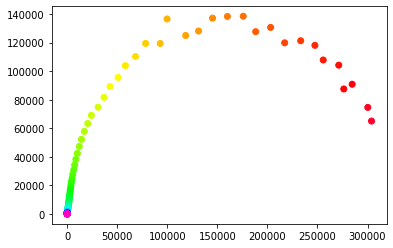

In [9]:
os.chdir('/home/pi/Desktop/Impedance')
foldname = datetime.today().strftime('%m-%d-%Y')
now = datetime.now()
currtime = now.strftime("%m%d%y%H%M")
currtime_format = now.strftime("%m/%d/%y %H:%M")

if os.path.isdir(foldname) is False:
    os.mkdir(foldname)

os.chdir(foldname)

SMU, DMM, LCR, AFG = CVCommands.inst_connect(
    SMUon = True, DMMon = True, LCRon = True, AFGon = False)

error = False

CVCommands.sampName = sampName
CVCommands.LCR_configure()
CVCommands.LCR_ZTD()
CVCommands.checkContact()
#Function to collect LCR output (num = number of points to average over, delay = delay between measurements in s)

#Collect measurement (iAmpl = initial AC amplitude in V, fAmpl = final AC amplitude in V
#step_ampl = number of AC amplitude steps, num_avg = number of measurements to average over
#avg_delay = delay between measurements in s, delay = delay between changing conditions in s,
#measbias = the setpoint DC bias)


######################################################

if holdbias is True:

    CVCommands.setBias(hold_val,True,False)

    print('Waiting')
    time.sleep(hold_time)

CVCommands.set_oscVolt(amp)

#This is the actual scan
#setBias(Vbias,True)

Z_arr = []
θ_arr = []
D_arr = []
F_arr = []

for i in tqdm(np.logspace(freq_i,freq_f,freq_step)):
    CVCommands.setFreq(i)
    
    Z_temp, θ_temp, D_temp= CVCommands.getData()
    
    Z_arr.append(Z_temp)
    θ_arr.append(θ_temp)
    D_arr.append(D_temp)
    F_arr.append(float(LCR.query(':FREQ?')))


        
CVCommands.offBias()
LCR.write(':TRIG INT')
x = [Z_arr[i]*np.cos(math.pi/180*θ_arr[i]) for i in range(len(Z_arr))]
y = [-Z_arr[i]*np.sin(math.pi/180*θ_arr[i]) for i in range(len(Z_arr))]
for i in range(len(x)):
    if math.isnan(x[i]):
        F_arr[i] = np.nan

tempdict = {
    'Zre' : x,
    '-Zim' : y,
    'D' : D_arr,
    'Frequency (F)' : F_arr
}

info_labels = ['Sample Name: ','V bias: ','Freq start: ','Freq final: ','Freq steps: ','Time: ']
info_data = [sampName,Vbias,freq_i,freq_f,freq_step,currtime_format]

dictlen = len(tempdict[list(tempdict.keys())[0]])
infolen = len(info_data)

if dictlen >= infolen:
    info_labels = info_labels+[np.nan]*(dictlen-infolen)
    info_data = info_data+[np.nan]*(dictlen-infolen)
else:
    for i in tempdict:
        tempdict[i] = tempdict[i]+[np.nan]*(infolen-dictlen)

tempdict['Info1'] = info_labels
tempdict['Info2'] = info_data
        
print('Saving as: '+''.join([sampName,'_impedance','_',currtime,'_',"{:.0f}".format(Vbias),'V']))
globals()[''.join([sampName,'_impedance','_',currtime,'_',"{:.0f}".format(Vbias),'V'])] = pd.DataFrame(tempdict)
globals()[''.join([sampName,'_impedance','_',currtime,'_',"{:.0f}".format(Vbias),'V'])].to_csv(''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(Vbias),'V']),sep='\t')


plt.scatter(x,y,c=np.log10(F_arr),cmap='gist_rainbow')
#plt.yscale('log')

if error == False:
    time.sleep(0.5)
    CVCommands.playchest()
else:
    CVCommands.playrand(10,0.05)

In [ ]:
plt.scatter(x,y,c=np.log10(F_arr),cmap='gist_rainbow')

In [ ]:
info_labels = ['Sample Name: ','V bias: ','Freq start: ','Freq final: ','Freq steps: ','Time: ']
info_data = [sampName,Vbias,freq_i,freq_f,freq_step,currtime_format]

dictlen = len(tempdict[list(tempdict.keys())[0]])
infolen = len(info_data)

if dictlen >= infolen:
    info_labels = info_labels+[np.nan]*(dictlen-infolen)
    info_data = info_data+[np.nan]*(dictlen-infolen)
else:
    for i in tempdict:
        tempdict[i] = tempdict[i]+[np.nan]*(infolen-dictlen)

tempdict['Info1'] = info_labels
tempdict['Info2'] = info_data
        
print('Saving as: '+''.join([sampName,'_impedance','_',currtime,'_',"{:.0f}".format(Vbias),'V']))
globals()[''.join([sampName,'_impedance','_',currtime,'_',"{:.0f}".format(Vbias),'V'])] = pd.DataFrame(tempdict)
globals()[''.join([sampName,'_impedance','_',currtime,'_',"{:.0f}".format(Vbias),'V'])].to_csv(''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(Vbias),'V']),sep='\t')

        
plt.scatter(x,y,c=F_arr,cmap='gist_rainbow')